# First Modeling

Here I'll take my work from the two previous notebooks, and I'll try some simple modeling

I'm going to try 3 different styles of starter models:
 - Regression
 - Binary classification
 - Tertiary classification

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import wikipedia
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix

### Tidying up

Let's take our data from the 'games_with_plots.csv' file that we exported from the [wikiscraping](./02_wikiscraping.ipynb) notebook

In [3]:
# games_with_plots = pd.read_csv('../data/games_with_plots.csv')
games_with_plots = pd.read_csv('../data/final_plots.csv')
games_with_plots.head()

,Unnamed: 0,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,plots
0,0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E,Wii Sports consists of five separate sports ga...
1,2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,Mario Kart Wii is a kart racing game featuring...
2,3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E,Wii Sports Resort is a sports video game set i...
3,6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E,Mario and Princess Peach are walking together ...
4,7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E,Wii Play is a party game consisting of nine mi...


Grab just the columns we're interested in for now

In [4]:
important_columns = ['Name', 'Platform', 'Publisher', 'Developer'
                     'Critic_Score', 'Global_Sales', 'Year_of_Release',
                     'plots', 'Rating', ]
drop_cols = ['Unnamed: 0', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
gdf = games_with_plots.drop(columns = drop_cols).copy()

Put a little text cleaner here for now, i'm not really sure if this is necessary but w/e 

\***move to src folder soon**\*

In [5]:
def clean_text(text):
    import string
    words = [''.join(ch for ch in s if ch not in string.punctuation) for s in text.split()]
    return ' '.join(words).lower()

Let's do some minor data cleaning

In [6]:
gdf.plots = gdf.plots.apply(clean_text)
# gdf.release_date = pd.to_datetime(gdf.release_date, errors='coerce')
# gdf.critic_score = gdf.critic_score.astype(float)
gdf.sample(5)

,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,plots
2156,Sword Art Online: Lost Song,PSV,2015.0,Role-Playing,Namco Bandai Games,0.36,70.0,4.0,7.1,27.0,"Bandai Namco Games, Artdink",T,after the events of hollow fragment and escapi...
3754,Night at the Museum: Battle of the Smithsonian,X360,2009.0,Action,Majesco Entertainment,0.11,50.0,15.0,7.1,8.0,"Majesco Games, Majesco",E10+,three years after the events of the first film...
4982,Red Ninja: End of Honor,XB,2005.0,Action,Vivendi Games,0.02,46.0,25.0,4,5.0,Tranji,M,the game is set in 16th century japan during t...
3472,Rio,PS3,2011.0,Misc,THQ,0.14,65.0,8.0,tbd,NaN,Eurocom Entertainment Software,E10+,in brazil various exotic birds are smuggled ou...
3617,SSX 3,GBA,2003.0,Sports,Electronic Arts,0.12,63.0,14.0,tbd,NaN,Visual Impact,E,ssx 3 is a snowboard racing game played from a...


Looking pretty clean, let's go ahead

### Modeling

We'll get our main data split up here

In [14]:
y = gdf[['Critic_Score']]
X = gdf[['Developer', 'plots']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

Let's vectorize our plots for our first simple model, and let's just start with 1000 features

In [15]:
tf = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)

First model we'll try is just a vanilla Random Forest Regressor

In [21]:
lr = LinearRegression()
lr.fit(X_train_tf, y_train.values.ravel())

LinearRegression()

In [22]:
lr.score(X_test_tf, y_test.values.ravel())

0.1423960449744146

Looks like an FSM score to me....

## New idea: Binning our target

I'm interested in trying to make a simpler model by binning our target variable. First I would like to try just two classifications of critical success, successful or unsuccessful

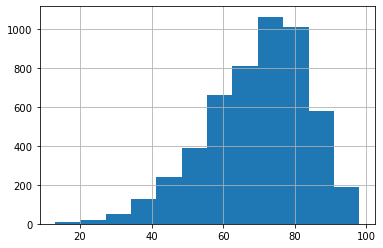

In [24]:
gdf.Critic_Score.hist(bins=12);

This left-skewed distribution is typical of reviews, so maybe we should make our first split at 70

In [25]:
gdf['success'] = (gdf['Critic_Score'] > 70).astype(int)
gdf.head()

,Name,Platform,Year_of_Release,Genre,Publisher,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,plots,success
0,Wii Sports,Wii,2006.0,Sports,Nintendo,82.53,76.0,51.0,8,322.0,Nintendo,E,wii sports consists of five separate sports ga...,1
1,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,35.52,82.0,73.0,8.3,709.0,Nintendo,E,mario kart wii is a kart racing game featuring...,1
2,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,32.77,80.0,73.0,8,192.0,Nintendo,E,wii sports resort is a sports video game set i...,1
3,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,29.80,89.0,65.0,8.5,431.0,Nintendo,E,mario and princess peach are walking together ...,1
4,Wii Play,Wii,2006.0,Misc,Nintendo,28.92,58.0,41.0,6.6,129.0,Nintendo,E,wii play is a party game consisting of nine mi...,0


In [26]:
gdf.success.value_counts()

1    2687
0    2456
Name: success, dtype: int64

### Modeling again

Let's get going with a classifier model

I'll use SVM as it tends to work well for these text-based things

In [27]:
y = gdf[['success']]
X = gdf[['Developer', 'plots']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [28]:
tf = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)

In [29]:
svm = SGDClassifier()
svm.fit(X_train_tf, y_train.values.ravel())

SGDClassifier()

Let's see how our accuracy for our base classifier model does

In [30]:
svm.score(X_test_tf, y_test)

0.6772939346811819

In [31]:
confusion_matrix(y_test, svm.predict(X_test_tf))

array([[394, 243],
       [172, 477]], dtype=int64)

**Not a bad place to start**,  but not great either

Last thing I want to try is a tertiary classification

Let's make a function to divide up the scores into 3 bins

In [7]:
def success(value):
    '''
    function for binning the critic scores
    '''
    
    if value > 70:
        if value > 80:
            return 2
        return 1
    return 0

Apply our function and check the class sizes

In [8]:
gdf['success'] = gdf.Critic_Score.apply(success)

In [9]:
gdf.success.value_counts()

0    2456
1    1501
2    1186
Name: success, dtype: int64

I'm just going to do the same things I did for the binary here

In [11]:
y = gdf[['success']]
X = gdf[['Developer', 'plots']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [12]:
tf = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tf = tf.fit_transform(X_train.plots)
X_test_tf = tf.transform(X_test.plots)

I don't know if this is a good classifier for this but we'll try it

In [39]:
svm = SGDClassifier()
svm.fit(X_train_tf, y_train.values.ravel())

SGDClassifier()

In [40]:
svm.score(X_test_tf, y_test)

0.5855365474339036

Alright I need to do more testing here, and actually decide on what type of thing I'm doing.....

In [15]:
rf = RandomForestClassifier()
rf.fit(X_train_tf, y_train.values.ravel())

RandomForestClassifier()

In [16]:
rf.score(X_test_tf, y_test)

0.6423017107309487

**bang** I think I'm going to stick with the tertiary classification for now.

I will also need to explore stemming/lemmatizing words to clean this stuff up a little bit.

In [43]:
gdf.to_csv('../data/fsm_set.csv')